✓ Libraries imported successfully!

📚 Fetching reviews from Planet Terp...
  → Fetching reviews for Ilchul Yoon...
  → Fetching reviews for Nelson Padua-Perez...
  → Fetching reviews for Fawzi Emad...
  → Fetching reviews for Larry Herman...
  → Fetching reviews for Mohammad Nayeem Teli...

✓ Collected 1207 reviews total!

Dataset preview:
     professor                                             review  rating
0  Ilchul Yoon  Really nice guy. Co-taught CMSC131 with Dr. Pu...       5
1  Ilchul Yoon  Really, super nice. He's very excited and enth...       5
2  Ilchul Yoon  I work for him and he cares so much about his ...       5
3  Ilchul Yoon  Amazing professor! So friendly and approachabl...       5
4  Ilchul Yoon  Great prof, he's very enthusiastic about CS. H...       5

Rating distribution:
rating
1    254
2    134
3    129
4    220
5    470
Name: count, dtype: int64

✓ Data saved to 'professor_reviews.csv'

✓ Cleaned dataset: 1207 reviews
  → Training set: 965 reviews
  → Test s

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ BERT model loaded!

🔤 Tokenizing reviews...
✓ Tokenization complete!
✓ PyTorch datasets created!

🏋️ Training the model...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
10,1.711500
20,1.603900
30,1.547900
40,1.564500
50,1.441100
60,1.491700
70,1.465700
80,1.251900
90,1.114400
100,1.026400


✓ Training complete!
✓ Model saved!

🔮 Making predictions on test set...



✓ Accuracy: 60.33%

📊 Creating visualizations...


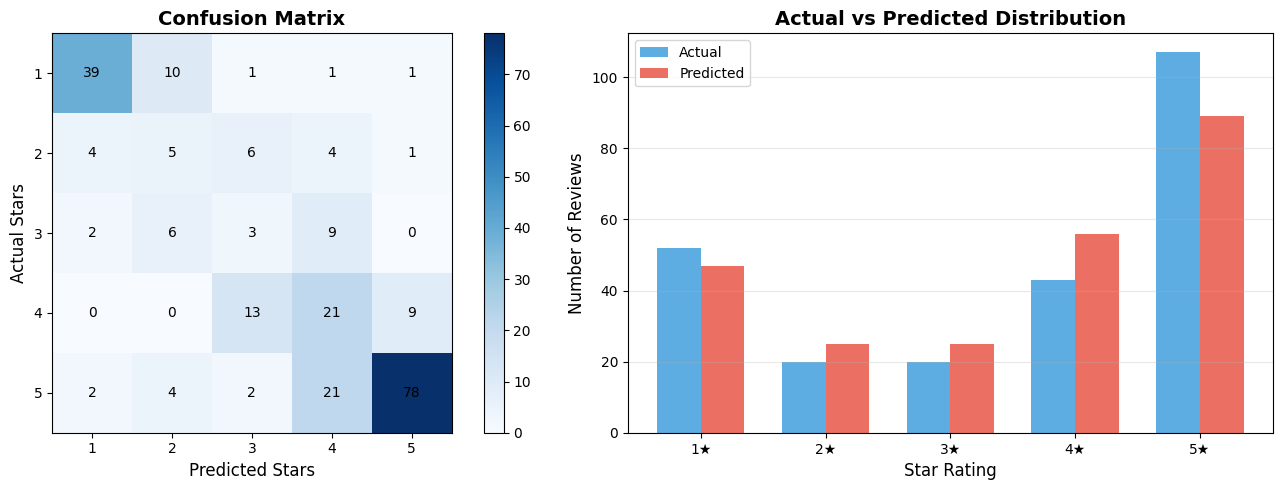

✓ Visualizations saved!

📝 Example Predictions:

Review: Herman is NOT my kind of professor. He is too by the book, uptight and relies on you to learn the ma...
Actual: 2★  |  Predicted: 4★  ✗
--------------------------------------------------------------------------------

Review: Nelson is an absolute gem of a professor. He explains everything very clearly/eloquently, goes over ...
Actual: 5★  |  Predicted: 5★  ✓
--------------------------------------------------------------------------------

Review: Fawzi is a good lecturer. I will give him credit in that he is able to present the material clearly ...
Actual: 1★  |  Predicted: 2★  ✗
--------------------------------------------------------------------------------

Review: didnt go to a single lecture, didnt watch a single recording, spammed the practice exam 2 days befor...
Actual: 5★  |  Predicted: 2★  ✗
--------------------------------------------------------------------------------

Review: Easy to fall asleep to. But other than 

In [ ]:

#Install and Import Libraries

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

np.random.seed(42)
torch.manual_seed(42)


# Get Professor Reviews from Planet Terp API

# Choose 5 professors (you can change these)
professors = ["Ilchul Yoon","Elias Gonzalez","Roohollah Ebrahimian","Larry Herman",
    "Timothy Pilachowski"]

def get_professor_reviews(professor_name):
    """Fetch reviews for a professor from Planet Terp API"""
    url = "https://planetterp.com/api/v1/professor"
    params = {"name": professor_name,
        "reviews": "true"}

    response = requests.get(url, params=params)
    data = response.json()

    return data

# Collect all reviews
all_reviews = []

for prof in professors:
    data = get_professor_reviews(prof)

    # Extract reviews if they exist
    if 'reviews' in data and data['reviews']:
        for review in data['reviews']:
            all_reviews.append({'professor': prof,
                'review': review['review'],
                'rating': review['rating']})

# Create DataFrame
df = pd.DataFrame(all_reviews)

print(f"\nCollected {len(df)} reviews total!")
print(f"\nDataset preview:")
print(df.head())

print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

# Save raw data
df.to_csv('professor_reviews.csv', index=False)


#Prepare Data for Training


df = df.dropna(subset=['review', 'rating'])

# Convert ratings to integers (1-5)
df['rating'] = df['rating'].astype(int)

# Only keep ratings 1-5
df = df[df['rating'].between(1, 5)]

# Create labels (0-indexed for model: 0=1star, 1=2star, etc.)
df['label'] = df['rating'] - 1

print(f"\n✓ Cleaned dataset: {len(df)} reviews")

# Split into train and test sets (80/20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set: {len(train_df)} reviews")
print(f"Test set: {len(test_df)} reviews")


# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=5)


#Tokenize the Reviews


# Tokenize training data
train_encodings = tokenizer(list(train_df['review']),
    truncation=True,
    padding=True,
    max_length=512)

# Tokenize test data
test_encodings = tokenizer(
    list(test_df['review']),
    truncation=True,
    padding=True,
    max_length=512)


#Create PyTorch Datasets

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = ReviewDataset(train_encodings, list(train_df['label']))
test_dataset = ReviewDataset(test_encodings, list(test_df['label']))


# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    save_steps=500,)

# Create Trainer
trainer = Trainer(model=model,args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,)

# Train the model
trainer.train()


# Save the fine-tuned model
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')


# Get predictions
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Convert back to star ratings (add 1)
predicted_stars = pred_labels + 1
actual_stars = test_df['rating'].values

# Calculate accuracy
accuracy = accuracy_score(actual_stars, predicted_stars)
print(f"\nAccuracy: {accuracy:.2%}")

#Visualizations

print("\nCreating visualizations...")

# 1. Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(actual_stars, predicted_stars, labels=[1, 2, 3, 4, 5])
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Stars', fontsize=12)
axes[0].set_ylabel('Actual Stars', fontsize=12)
axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].set_yticks([0, 1, 2, 3, 4])
axes[0].set_xticklabels(['1', '2', '3', '4', '5'])
axes[0].set_yticklabels(['1', '2', '3', '4', '5'])

# Add numbers to confusion matrix
for i in range(5):
    for j in range(5):
        text = axes[0].text(j, i, cm[i, j],
                           ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=axes[0])

# 2. Prediction Distribution Comparison
star_labels = ['1★', '2★', '3★', '4★', '5★']
x = np.arange(len(star_labels))
width = 0.35

actual_counts = [sum(actual_stars == i) for i in range(1, 6)]
predicted_counts = [sum(predicted_stars == i) for i in range(1, 6)]

axes[1].bar(x - width/2, actual_counts, width, label='Actual', color='#3498db', alpha=0.8)
axes[1].bar(x + width/2, predicted_counts, width, label='Predicted', color='#e74c3c', alpha=0.8)
axes[1].set_title('Actual vs Predicted Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Star Rating', fontsize=12)
axes[1].set_ylabel('Number of Reviews', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(star_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved!")

# 10: Show Example Predictions

print("\n Example Predictions:")
print("=" * 80)

sample_indices = np.random.choice(len(test_df), min(10, len(test_df)), replace=False)

for idx in sample_indices:
    review_text = test_df.iloc[idx]['review']
    actual = actual_stars[idx]
    predicted = predicted_stars[idx]

    # Truncate long reviews
    if len(review_text) > 100:
        review_text = review_text[:100] + "..."

    print(f"\nReview: {review_text}")
    print(f"Actual: {actual}★  |  Predicted: {predicted}★  {'✓' if actual == predicted else '✗'}")
    print("-" * 80)

#  11: Summary Statistics
# --------------------------------------------

print("\n Summary Statistics:")
print("=" * 80)
print(f"Total Reviews: {len(df)}")
print(f"Training Reviews: {len(train_df)}")
print(f"Test Reviews: {len(test_df)}")
print(f"Model Accuracy: {accuracy:.2%}")
print(f"Correct Predictions: {sum(actual_stars == predicted_stars)}/{len(actual_stars)}")

# Calculate accuracy by star rating
print("\nAccuracy by Star Rating:")
for star in range(1, 6):
    mask = actual_stars == star
    if sum(mask) > 0:
        star_accuracy = accuracy_score(actual_stars[mask], predicted_stars[mask])
        print(f"  {star}★: {star_accuracy:.2%} ({sum(mask)} reviews)")
